# **DATA GENERATION**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform, pdist
import time
from sklearn.metrics import accuracy_score

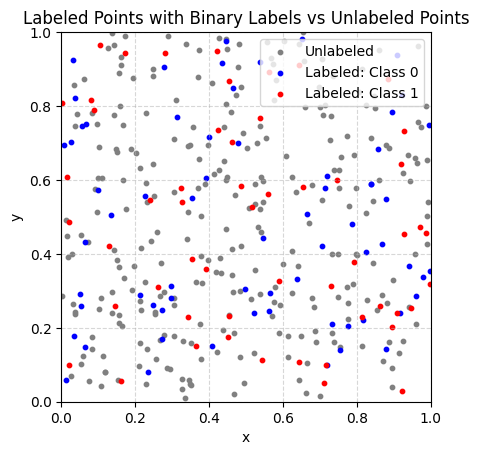

In [ ]:
#Let's have 120 labeled and 280 unlabeled data points — so 400 points total.
U = 280 #number of unlabeled data points
L = 120 #number of labeled data points

#random seed for reproducibility
np.random.seed(77)

#generation of 400 random points uniformly distributed in [0,1]^2
points = np.random.rand(U + L, 2)

#split the dataset
labeled_points = points[:L] #The first 120 points are treated as labeled.
unlabeled_points = points[L:] #The remaining 280 as unlabeled.
#in order to label a portion (30%) of the data points

#generate random binary labels
labels = np.random.randint(0, 2, size=(L, 1))
#and concatenates these labels as a third column → so each labeled point becomes (x, y, label)
labeled_points = np.hstack((labeled_points, labels))
labeled_labels = labeled_points[:, 2]

#WEIGHTS and SIMILARITY SCORES computation
labeled_coords = labeled_points[:, :2]
W = cdist(labeled_coords, unlabeled_points, metric='euclidean') #computes the Euclidean distance between every labeled and unlabeled point.
#so that W[i,j] is the distance between labeled point i and unlabeled point j.
W_hat = squareform(pdist(unlabeled_points, metric='euclidean')) #computes pairwise distances among all unlabeled points, returning a condensed vector.
#so that W_hat[i,j] is the distance between unlabeled point i and unlabeled point j.

#Since small distances imply stronger similarity, taking the reciprocal of the distances converts them to similarity scores.
epsilon = 1e-8 #The small epsilon avoids division by zero (when two points are identical).
W = 1 / (W + epsilon) #W[i,j] is large if labeled i and unlabeled j are close.
W_hat = 1 / (W_hat + epsilon) #W_hat[i,j] is large if unlabeled point i and unlabeled point j are close.
np.fill_diagonal(W_hat, 0.0)

#plot
plt.scatter(unlabeled_points[:, 0], unlabeled_points[:, 1], color='gray', s=10, label='Unlabeled')
plt.scatter(labeled_points[labeled_points[:, 2] == 0][:, 0], labeled_points[labeled_points[:, 2] == 0][:, 1],
            color='blue', s=10, label='Labeled: Class 0')
plt.scatter(labeled_points[labeled_points[:, 2] == 1][:, 0], labeled_points[labeled_points[:, 2] == 1][:, 1],
            color='red', s=10, label='Labeled: Class 1')
plt.title('Labeled Points with Binary Labels vs Unlabeled Points')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# **LOSS FUNCTION**

In [ ]:
#LOSS FUNCTION

def loss_function(W, W_hat, labeled_labels, y_unlabeled):

    U = W_hat.shape[0]
    L = labeled_labels.shape[0]

    #first term: weighted sum of the differences between labeled and unlabeled data points
    term1 = 0
    for i in range(L):
        for j in range(U):
            diff = y_unlabeled[j] - labeled_labels[i]
            term1 += W[i, j] * (diff ** 2)

    #second term: half weighted sum of the differences between unlabeled data points
    term2 = 0
    for i in range(U):
        for j in range(U):
            diff = y_unlabeled[i] - y_unlabeled[j]
            term2 += W_hat[i, j] * (diff ** 2)

    term2 *= 0.5

    return term1 + term2

#FIRST DERIVATE OF THE LOSS FUNCTION

def gradient_yj(j, W, W_hat, labeled_labels, y_unlabeled):

    U = W_hat.shape[0]
    L = labeled_labels.shape[0]

    #first term first derivate with respect to y_j
    term1 = 0
    for i in range(L):
        term1 += W[i, j] * (y_unlabeled[j] - labeled_labels[i])

    #second term first derivate with respect to y_j
    term2 = 0
    for i in range(U):
        term2 += W_hat[i, j] * (y_unlabeled[j] - y_unlabeled[i])

    #return 2*term1 + term2
    return  2*term1 + 2*term2

# **GRADIENT DESCENT ALGORITHMS**

In [ ]:
#def gradient_descent
###inputs
#   W : ndarray (L, U) : Similarity matrix between labeled and unlabeled points.
#   W_hat : ndarray (U, U) : Similarity matrix among unlabeled points.
#   labeled_labels : ndarray (L,) : Binary labels for labeled data (0 or 1).
#   loss_function : callable : Function f(W, W_hat, labeled_labels, y_unlabeled) returning scalar loss.
#   gradient_yj : callable : Function grad_yj(j, W, W_hat, labeled_labels, y_unlabeled) returning derivative wrt y_j.
#   random_state : int : Random seed for reproducibility.
#   learning_rate : float : Base learning rate for gradient descent.
#   max_iter : int : Maximum number of iterations.
#   tol : float : Stopping tolerance on gradient norm.
#   max_no_improve : int : Max consecutive iterations without improvement before stopping.
#   step_size : {"fixed", "armijo", "line_search"} : Rule for step size selection.
#   threshold : float : Threshold to binarize final predictions.
#   verbose : bool : Print progress.

###outputs
#   history : dict : Keys: "loss", "gap" (duality gap proxy at each iteration)
#   labels_pred : np.ndarray : Final binarized labels in {0,1}.
#   it+1 : the number of iterations occured


def gradient_descent(
    W, W_hat, labeled_labels,
    loss_function, gradient_yj,
    random_state=42,
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-6,
    max_no_improve=50,
    step_size="fixed",
    threshold=0.5,
    verbose=True,
    armijo_delta=0.5,
    armijo_gamma=0.05
):
    np.random.seed(random_state)
    U = W_hat.shape[0]
    L = labeled_labels.shape[0]
    history_loss, history_gap, y_list = [], [], []
    best_loss = np.inf
    no_improve_counter = 0

    #Randomly initilize the labels
    y_unlabeled = np.random.rand(U)

    def full_gradient(y):
        grad = np.zeros(U)
        for j in range(U):
            grad[j] = gradient_yj(j, W, W_hat, labeled_labels, y)
        return grad

    for it in range(max_iter):
        grad = full_gradient(y_unlabeled) #computes the gradient with respect to every label
        grad_norm = np.linalg.norm(grad) #computes the gradient norm, to use it as a duality gap proxy stopping criterion

        #computes and stores the loss function value and its correspondent duality gap value, to allow for post analysis on algorithm convergence
        loss = loss_function(W, W_hat, labeled_labels, y_unlabeled)
        history_loss.append(loss)
        history_gap.append(grad_norm)

        #stopping criteria checking
        #duality gap criteria
        if grad_norm < tol:
            if verbose:
                print(f"[STOP] Gradient norm {grad_norm:.2e} < tol at iteration {it}")
            break
        #no improvement criteria
        if it > 0 and loss >= best_loss - 1e-12:
            no_improve_counter += 1
        else:
            no_improve_counter = 0
            best_loss = loss
        if no_improve_counter >= max_no_improve:
            if verbose:
                print(f"[STOP] No improvement for {max_no_improve} iterations.")
            break

        #step size computation
        #fixed step size rule: the learning rate is constant across all iterations
        if step_size == "fixed":
            eta = learning_rate

        #armijo rule:
        #alpha = δ^m * Δ_k, with Δ_k = learning_rate, with m=0,1,2,... until
        #condition: f(y - eta*grad) <= f(y) - gamma*eta*||grad||^2 is met
        elif step_size == "armijo":
            delta = armijo_delta
            gamma = armijo_gamma
            eta = learning_rate #Δ_k
            while True:
                new_y = y_unlabeled - eta * grad
                new_loss = loss_function(W, W_hat, labeled_labels, new_y)
                if new_loss <= loss - gamma * eta * (grad_norm ** 2):
                    break
                eta *= delta
            #eta is the accepted Armijo step size

        elif step_size == "line_search":
            # Exact line search for quadratic loss f(y) = y^T Q y - 2 c^T y
            eps = 1e-6
            grad = full_gradient(y_unlabeled)
            grad_next = full_gradient(y_unlabeled + eps * grad)
            Q_grad_approx = (grad_next - grad) / eps  # ≈ H * grad
            denom = grad @ Q_grad_approx
            eta_num = grad @ grad
            eta = eta_num / (denom + 1e-12)
            eta = max(1e-10, min(eta, 1.0))  # limit to reasonable range

        else:
            raise ValueError("step_size must be one of {'fixed', 'armijo', 'line_search'}")

        #classical gradient descent update
        y_unlabeled = y_unlabeled - eta * grad

        if verbose and it % 10 == 0:
            print(f"Iter {it:4d} | loss={loss:.6f} | ||grad||={grad_norm:.3e} | step={eta:.3e}")

    #attributes the labels to the unlabeled data points based on the threshold
    #so, if y_unlabeled[i] >= threshold, then labels_pred[i] = 1;
    #otherwise lables_pred[i] = 0
    labels_pred = (y_unlabeled >= threshold).astype(int)

    history = {
        "loss": np.array(history_loss),
        "gap": np.array(history_gap),
    }

    return history, labels_pred, it+1


In [ ]:
#def block_oordinate_gradient_descent
###inputs
#   W : ndarray (L, U) : Similarity matrix between labeled and unlabeled points.
#   W_hat : ndarray (U, U) : Similarity matrix among unlabeled points.
#   labeled_labels : ndarray (L,) : Binary labels for labeled data (0 or 1).
#   loss_function : callable : Function f(W, W_hat, labeled_labels, y_unlabeled) returning scalar loss.
#   gradient_yj : callable : Function grad_yj(j, W, W_hat, labeled_labels, y_unlabeled) returning derivative wrt y_j.
#   random_state : int : Random seed for reproducibility.
#   learning_rate : float : Base learning rate for gradient descent.
#   max_iter : int : Maximum number of iterations.
#   tol : float : Stopping tolerance on gradient norm.
#   max_no_improve : int : Max consecutive iterations without improvement before stopping.
#   threshold : float : Threshold to binarize final predictions.
#   verbose : bool : Print progress.

###outputs
#   history : dict : Keys: "loss", "gap" (duality gap proxy at each iteration)
#   labels_pred : np.ndarray : Final binarized labels in {0,1}.
#   n_iter : int :the number of iterations occured

def block_coordinate_gradient_descent(
    W, W_hat, labeled_labels,
    loss_function, gradient_yj,
    random_state=42,
    learning_rate=0.01,     # kept for interface consistency
    max_iter=1000,
    tol=1e-6,
    max_no_improve=50,
    threshold=0.5,
    verbose=True
):

    np.random.seed(random_state)
    U = W_hat.shape[0]
    L = labeled_labels.shape[0]
    history_loss, history_gap, y_list = [], [], []
    best_loss = np.inf
    no_improve_counter = 0

    #randomly initilizes the labels
    y_unlabeled = np.random.rand(U)

    def full_gradient(y):
        grad = np.zeros(U)
        for j in range(U):
            grad[j] = gradient_yj(j, W, W_hat, labeled_labels, y)
        return grad

    #precomputes the Hessian diagonal elements for exact line search
    #each coordinate curvature will be: 2*(Σ_i W[i,j] + Σ_i W_hat[i,j])
    H_diag = np.zeros(U)
    for j in range(U):
        H_diag[j] = 2 * (np.sum(W[:, j]) + np.sum(W_hat[:, j]))

    for it in range(max_iter):
        grad = full_gradient(y_unlabeled) #computes the gradient with respect to every label
        grad_norm = np.linalg.norm(grad) #computes the gradient norm, to use it as a duality gap proxy stopping criterion
        loss = loss_function(W, W_hat, labeled_labels, y_unlabeled)

        #computes and stores the loss function value and its correspondent duality gap value, to allow for post analysis on algorithm convergence
        history_loss.append(loss)
        history_gap.append(grad_norm)

        #stopping criteria checking
        #duality gap criteria
        if grad_norm < tol:
            if verbose:
                print(f"[STOP] Gradient norm {grad_norm:.2e} < tol at iteration {it}")
            break
        #no improvement criteria
        if it > 0 and loss >= best_loss - 1e-12:
            no_improve_counter += 1
        else:
            no_improve_counter = 0
            best_loss = loss
        if no_improve_counter >= max_no_improve:
            if verbose:
                print(f"[STOP] No improvement for {max_no_improve} iterations.")
            break

        #Gauss–Southwell rule: picks the coordinate with largest |grad_j|
        j_star = np.argmax(np.abs(grad))

        #and then computes an exact line search for coordinate j_star
        #since the loss function is quadratic and convex
        #we set the learning rate equal to the eta that minimizes the first derivative of the loss function with respect to eta
        eta = 1.0 / H_diag[j_star]
        y_unlabeled[j_star] -= eta * grad[j_star]

        if verbose and it % 10 == 0:
            print(f"Iter {it:4d} | loss={loss:.6f} | ||grad||={grad_norm:.3e} | j*={j_star:3d} | step={eta:.3e}")

    #attributes the labels to the unlabeled data points based on the threshold
    #so, if y_unlabeled[i] >= threshold, then labels_pred[i] = 1;
    #otherwise lables_pred[i] = 0
    labels_pred = (y_unlabeled >= threshold).astype(int)
    history = {
        "loss": np.array(history_loss),
        "gap": np.array(history_gap)
    }

    return history, labels_pred, it + 1


In [ ]:
#def coordinate_minimization_gauss_seidel
###inputs
#   W : ndarray (L, U) : Similarity matrix between labeled and unlabeled points.
#   W_hat : ndarray (U, U) : Similarity matrix among unlabeled points.
#   labeled_labels : ndarray (L,) : Binary labels for labeled data (0 or 1).
#   loss_function : callable : Function f(W, W_hat, labeled_labels, y_unlabeled) returning scalar loss.
#   gradient_yj : callable : Function grad_yj(j, W, W_hat, labeled_labels, y_unlabeled) returning derivative wrt y_j.
#   random_state : int : Random seed for reproducibility.
#   max_iter : int : Maximum number of iterations.
#   tol : float : Stopping tolerance on gradient norm.
#   max_no_improve : int : Max consecutive iterations without improvement before stopping.
#   threshold : float : Threshold to binarize final predictions.
#   verbose : bool : Print progress.

###outputs
#   history : dict : Keys: "loss", "gap" (duality gap proxy at each iteration)
#   labels_pred : np.ndarray : Final binarized labels in {0,1}.
#   n_iter : int :the number of iterations occured

def coordinate_minimization_gauss_seidel(
    W, W_hat, labeled_labels,
    loss_function, gradient_yj,
    random_state=42,
    max_iter=1000,
    tol=1e-6,
    max_no_improve=50,
    threshold=0.5,
    verbose=True
):
    np.random.seed(random_state)
    U = W_hat.shape[0]
    L = labeled_labels.shape[0]
    history_loss, history_gap = [], []
    best_loss = np.inf
    no_improve_counter = 0

    # initialize
    y_unlabeled = np.random.rand(U)


    # precompute weights to simplify updates
    sum_W = np.sum(W, axis=0)          # shape (U,)
    sum_W_hat = np.sum(W_hat, axis=0)  # shape (U,)

    # evaluate convergence metrics
    grad = np.zeros(U)

    for it in range(max_iter):
        for j in range(U):
              grad[j] = gradient_yj(j, W, W_hat, labeled_labels, y_unlabeled)

        grad_norm = np.linalg.norm(grad)

        loss = loss_function(W, W_hat, labeled_labels, y_unlabeled)
        history_loss.append(loss)
        history_gap.append(grad_norm)
        # perform Gauss–Seidel coordinate updates
        for j in range(U):
            # numerator: weighted contribution from labeled and unlabeled neighbors
            num_labeled = np.sum(W[:, j] * labeled_labels)
            num_unlabeled = np.sum(W_hat[j, :] * y_unlabeled)
            # denominator: total weight influencing y_j
            denom = np.sum(W[:, j]) + np.sum(W_hat[j, :])

            # closed-form coordinate minimization for quadratic loss
            if denom > 0:
                y_unlabeled[j] = (num_labeled + num_unlabeled) / denom


        # stopping checks
        if grad_norm < tol:
            if verbose:
                print(f"[STOP] Gradient norm {grad_norm:.2e} < tol at iteration {it}")
            break

        if it > 0 and loss >= best_loss - 1e-12:
            no_improve_counter += 1
        else:
            best_loss = loss
            no_improve_counter = 0
        if no_improve_counter >= max_no_improve:
            if verbose:
                print(f"[STOP] No improvement for {max_no_improve} iterations.")
            break

        if verbose and it % 10 == 0:
            print(f"Iter {it:4d} | loss={loss:.6f} | ||grad||={grad_norm:.3e}")

    labels_pred = (y_unlabeled >= threshold).astype(int)
    history = {"loss": np.array(history_loss), "gap": np.array(history_gap)}

    return history, labels_pred, it + 1


# **SYNTHETIC DATA EXPERIMENTS**

In [ ]:
#FIZED STEP SIZE : step size 0.0001 (arbitrary)

# --- RUN TEST ---
start_time = time.time()
history_gd_fss, labels_pred_gd_fss, n_iter_gd_fss = gradient_descent(
    W, W_hat, labeled_labels,
    loss_function, gradient_yj,
    step_size="fixed",
    learning_rate=0.0001,
    max_iter=5000, #247 iterations
    tol=1e-5,
    verbose=False
)
end_time = time.time()
runtime_gd_fss = end_time - start_time

print(f"\nConverged in {n_iter_gd_fss} iterations.")
print(f"Final loss: {history_gd_fss['loss'][-1]:.6f}")


Converged in 247 iterations.
Final loss: 24792.265144


In [ ]:
#LIPSCHITZ CONSTANT

#Since our loss function is quadratic and its first derivate is linear (e.g. DL(y) = Ay + b),
#the rate at which the gradient changes is just determined by the matrix multiplying y (A).
#So, how fast does the gradient change? It depends on the largest eigenvalue of A,
#because eigenvalues tell how much the matrix can 'stretch' a vector
        #and in gradient descent we ant to avoid
        #taking steps that overshoot the minimum.
        #If the function has directions where it changes very quickly (big eigenvalues)
        #we need to take smaller steps in those directions
        #(and therefore we use the inverse of Lipschitz constant)
#So, our loss functions has a Lipschitz constant equal to the largest eigenvalue of the matrix multiplying y (A),

#that, in our case, is W^T W + L_hat, with
    #W the already computed weights similarity matrix (between labeled and unlabeled data)
#L_hat = D_hat - W_hat, where
    #W_hat is the already computed similarity matrix (between unlabeled data)
    #D_hat is a diagonal matrix in which each entry is the row sum of W_hat
#this term appears in the second term of the loss function, that, in fact can also be written as y^T L_hat y,
#with the goal of penalizing differences between connected nodes, enforcing smoothness.

#Putting everything together, the loss function can also be written as
  #L(y) = y^T (W^T W + L_hat) y + (linear terms)
  #DL(y) = 2(W^T W + L_hat) y + (constant vector)
#And, therefore:
  #Lipschitz constant = 2 * lambda_max(W^T W + L_hat)

#Graph Laplacian
D_hat = np.diag(W_hat.sum(axis=1))
L_hat = D_hat - W_hat

#Approximation of Lipschitz constant
W_transpose_W = np.dot(W.T, W)
H = 2 * (W_transpose_W + L_hat)
eigvals = np.linalg.eigvalsh(H)
L_lipschitz = np.max(eigvals)

# Use 1 / L as learning rate
alpha_lipschitz = 1.0 / L_lipschitz
#print(f"Estimated Lipschitz constant: {L_lipschitz:.4f}, Step size (1/L): {alpha_lipschitz:.6f}")


# --- RUN TEST ---
start_time = time.time()
history_gd_Lp, labels_pred_gd_Lp, n_iter_gd_Lp = gradient_descent(
    W, W_hat, labeled_labels,
    loss_function, gradient_yj,
    step_size="fixed", ###
    learning_rate=alpha_lipschitz, ###
    max_iter=5000, #5000 not enough
    tol=1e-5,
    verbose=False
)
end_time = time.time()
runtime_gd_Lp = end_time - start_time

print(f"\nConverged in {n_iter_gd_Lp} iterations.")
print(f"Final loss: {history_gd_Lp['loss'][-1]:.6f}")


Converged in 5000 iterations.
Final loss: 24792.272316


In [ ]:
#ARMIJO RULE : initial step size 0.01

start_time = time.time()
history_gd_arm, labels_pred_gd_arm, n_iter_gd_arm = gradient_descent(
    W, W_hat, labeled_labels,
    loss_function, gradient_yj,
    step_size="armijo",
    learning_rate=0.01,
    max_iter=5000, #97 iterations, 311 seconds
    tol=1e-5,
    verbose=False
)
end_time = time.time()
runtime_gd_arm = end_time - start_time

print(f"\nConverged in {n_iter_gd_arm} iterations.")
print(f"Final loss: {history_gd_arm['loss'][-1]:.6f}")


Converged in 97 iterations.
Final loss: 24792.265144


In [ ]:
#EXACT LINE SEARCH

# --- RUN TEST ---
start_time = time.time()
history_gd_ls, labels_pred_gd_ls, n_iter_gd_ls = gradient_descent(
    W, W_hat, labeled_labels,
    loss_function, gradient_yj,
    step_size="line_search",
    learning_rate=0.0001,
    max_iter=5000, #50 iterations
    tol=1e-5,
    verbose=False
)
end_time = time.time()
runtime_gd_ls = end_time - start_time

print(f"\nConverged in {n_iter_gd_ls} iterations.")
print(f"Final loss: {history_gd_ls['loss'][-1]:.6f}")


Converged in 50 iterations.
Final loss: 24792.265144


In [ ]:
#BLOCK COORDINATE GRADIENT DESCENT

# --- RUN TEST ---
start_time = time.time()
history_bcgd, labels_pred_bcgd, n_iter_bcgd = block_coordinate_gradient_descent(
    W, W_hat, labeled_labels,
    loss_function, gradient_yj,
    learning_rate=0.0001,
    max_iter=5000,
    tol=1e-5,
    verbose=False
)
end_time = time.time()
runtime_bcgd = end_time - start_time

print(f"\nConverged in {n_iter_bcgd} iterations.")
print(f"Final loss: {history_bcgd['loss'][-1]:.6f}")


Converged in 5000 iterations.
Final loss: 24792.265144


In [ ]:
#COORDINATE MINIMIZATION

# --- RUN TEST ---
start_time = time.time()
history_cm, labels_pred_cm, n_iter_cm = coordinate_minimization_gauss_seidel(
    W, W_hat, labeled_labels,
    loss_function, gradient_yj,
    max_iter=5000, #30 iterations, 5 seconds
    tol=1e-5,
    verbose=False
)
end_time = time.time()
runtime_cm = end_time - start_time

print(f"\nConverged in {n_iter_cm} iterations.")
print(f"Final loss: {history_cm['loss'][-1]:.6f}")


Converged in 30 iterations.
Final loss: 24792.265144


# **SYNTHETIC EXPERIMENTS GRAPHICAL CONVERGENCE ANALYSIS**

In [ ]:
performance_synthetic = {}

#GD - Fixed Step Size (0.0001)
performance_synthetic["GD - Fixed Step Size (0.0001)"] = {
    "Final Objective" : history_gd_fss["loss"][-1],
    "Final Gap" : history_gd_fss["gap"][-1],
    "Runtime (s)" : runtime_gd_fss,
    "Iterations" : n_iter_gd_fss
}

#GD - Fixed Step Size (Lipschitz)
performance_synthetic["GD - Lipschitz Fixed Step Size"] = {
    "Final Objective" : history_gd_Lp["loss"][-1],
    "Final Gap" : history_gd_Lp["gap"][-1],
    "Runtime (s)" : runtime_gd_Lp,
    "Iterations" : n_iter_gd_Lp
}

#GD - Armijo Rule
performance_synthetic["GD - Armijo Rule"] = {
    "Final Objective" : history_gd_arm["loss"][-1],
    "Final Gap" : history_gd_arm["gap"][-1],
    "Runtime (s)" : runtime_gd_arm,
    "Iterations" : n_iter_gd_arm
}

#GD - Line Search
performance_synthetic["GD - Line Search"] = {
    "Final Objective" : history_gd_ls["loss"][-1],
    "Final Gap" : history_gd_ls["gap"][-1],
    "Runtime (s)" : runtime_gd_ls,
    "Iterations" : n_iter_gd_ls
}

#BCGD - Gauss Sothwell
performance_synthetic["BCGD"] = {
    "Final Objective" : history_bcgd["loss"][-1],
    "Final Gap" : history_bcgd["gap"][-1],
    "Runtime (s)" : runtime_bcgd,
    "Iterations" : n_iter_bcgd
}

#CM - Gauss Seidel
performance_synthetic["Coordinate Minimization"] = {
    "Final Objective" : history_cm["loss"][-1],
    "Final Gap" : history_cm["gap"][-1],
    "Runtime (s)" : runtime_cm,
    "Iterations" : n_iter_cm
}

df_perf_synthetic = pd.DataFrame(performance_synthetic).T
from IPython.display import display

display(df_perf_synthetic.style.set_caption("PERFORMANCE RESULTS on SYNTHETIC DATA"))


,Final Objective,Final Gap,Runtime (s),Iterations
GD - Fixed Step Size (0.0001),24792.265144,0.000009,38.247224,247.000000
GD - Lipschitz Fixed Step Size,24792.272316,3.183664,778.377508,5000.000000
GD - Armijo Rule,24792.265144,0.000551,236.864154,97.000000
GD - Line Search,24792.265144,0.000007,14.471834,50.000000
BCGD,24792.265144,0.000640,764.050574,5000.000000
Coordinate Minimization,24792.265144,0.000005,5.486262,30.000000


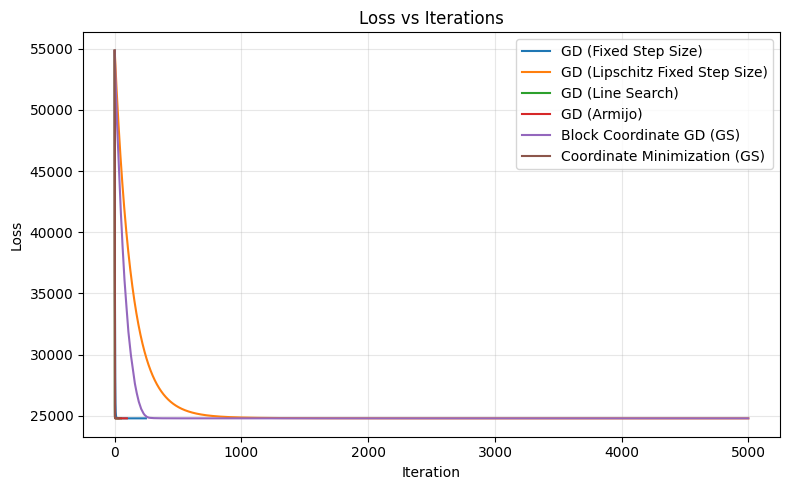

In [ ]:
# Dictionary for easy looping — label : history
histories = {
    "GD (Fixed Step Size)": history_gd_fss,
    "GD (Lipschitz Fixed Step Size)" : history_gd_Lp,
    "GD (Line Search)": history_gd_ls,
    "GD (Armijo)": history_gd_arm,
    "Block Coordinate GD (GS)": history_bcgd,
    "Coordinate Minimization (GS)": history_cm
}

plt.figure(figsize=(8, 5))
for label, hist in histories.items():
    plt.plot(hist["loss"], label=label)
plt.title("Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

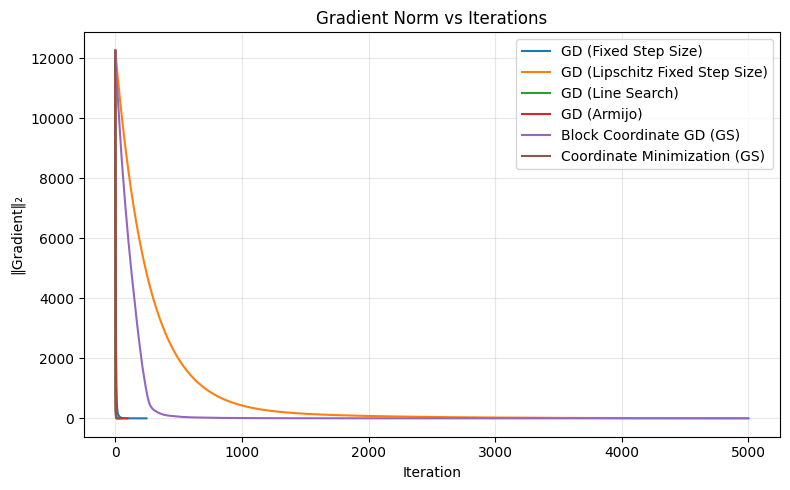

In [ ]:
plt.figure(figsize=(8, 5))
for label, hist in histories.items():
    plt.plot(hist["gap"], label=label)
plt.title("Gradient Norm vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("‖Gradient‖₂")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# **CANCER DATASET**

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
#This dataset is the Breast Cancer Wisconsin (Diagnostic) dataset.
#It contains measurements of cell nuclei from breast mass images,
#used to classify whether the tumor is malignant (cancerous) or benign (non-cancerous).
#It has 569 samples and 30 real-valued input features.
#Each feature is a statistical summary of cell nuclei charcteristic computed from digitized
#images (mean, standard error, worst value)

cancer = load_breast_cancer()

X=cancer.data
y=cancer.target
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(
    X, y, test_size=0.8, stratify=y
)

L_cancer = len(X_labeled) #number of unlabeled data points
U_cancer = len(X_unlabeled) #number of labeled data points

labeled_coords = X_labeled[:, :]
unlabeled_coords = X_unlabeled[:, :]

#WEIGHTS and SIMILARITY SCORES computation
W_cancer = cdist(labeled_coords, unlabeled_coords, metric='euclidean')
W_hat_cancer= squareform(pdist(unlabeled_coords, metric='euclidean'))
epsilon = 1e-8

W_cancer = 1 / (W_cancer + epsilon)
W_hat_cancer = 1 / (W_hat_cancer + epsilon)
np.fill_diagonal(W_hat_cancer, 0.0)

# **REAL DATA EXPERIMENTS**

In [ ]:
#FIZED STEP SIZE : step size 0.0001 (arbitrary)

# --- RUN TEST ---
start_time = time.time()
history_gd_fss_cancer, labels_pred_gd_fss_cancer, n_iter_gd_fss_cancer = gradient_descent(
    W=W_cancer, W_hat=W_hat_cancer, labeled_labels=y_labeled,
    loss_function=loss_function, gradient_yj=gradient_yj,
    step_size="fixed",
    learning_rate=0.0003,
    max_iter=5000,
    tol=1e-5,
    threshold=0.685,
    verbose=True
)
end_time = time.time()
runtime_gd_fss_cancer = end_time - start_time

print(f"\nConverged in {n_iter_gd_fss_cancer} iterations.")
print(f"Final loss: {history_gd_fss_cancer['loss'][-1]:.6f}")

Iter    0 | loss=6266.481176 | ||grad||=1.317e+03 | step=3.000e-04
Iter   10 | loss=3291.378226 | ||grad||=6.841e+02 | step=3.000e-04
Iter   20 | loss=2457.582092 | ||grad||=3.755e+02 | step=3.000e-04
Iter   30 | loss=2191.784580 | ||grad||=2.231e+02 | step=3.000e-04
Iter   40 | loss=2090.323022 | ||grad||=1.467e+02 | step=3.000e-04
Iter   50 | loss=2042.439981 | ||grad||=1.070e+02 | step=3.000e-04
Iter   60 | loss=2015.020626 | ||grad||=8.458e+01 | step=3.000e-04
Iter   70 | loss=1997.006283 | ||grad||=7.040e+01 | step=3.000e-04
Iter   80 | loss=1984.155507 | ||grad||=6.035e+01 | step=3.000e-04
Iter   90 | loss=1974.560757 | ||grad||=5.257e+01 | step=3.000e-04
Iter  100 | loss=1967.216287 | ||grad||=4.620e+01 | step=3.000e-04
Iter  110 | loss=1961.515426 | ||grad||=4.080e+01 | step=3.000e-04
Iter  120 | loss=1957.054415 | ||grad||=3.615e+01 | step=3.000e-04
Iter  130 | loss=1953.546497 | ||grad||=3.209e+01 | step=3.000e-04
Iter  140 | loss=1950.779557 | ||grad||=2.851e+01 | step=3.000

In [ ]:
#LIPSCHITZ CONSTANT

#Graph Laplacian
D_hat_cancer = np.diag(W_hat_cancer.sum(axis=1))
L_hat_cancer = D_hat_cancer - W_hat_cancer

#Approximation of Lipschitz constant
W_transpose_W_cancer = np.dot(W_cancer.T, W_cancer)
H_cancer = 2 * (W_transpose_W_cancer + L_hat_cancer)
eigvals_cancer = np.linalg.eigvalsh(H_cancer)
L_lipschitz_cancer = np.max(eigvals_cancer)

# Use 1 / L as learning rate
alpha_lipschitz_cancer = 1.0 / L_lipschitz_cancer
print(f"Estimated Lipschitz constant: {L_lipschitz_cancer:.4f}, Step size (1/L): {alpha_lipschitz_cancer:.6f}")


# --- RUN TEST ---
start_time = time.time()
history_gd_Lp_cancer, labels_pred_gd_Lp_cancer, n_iter_gd_Lp_cancer = gradient_descent(
    W=W_cancer, W_hat=W_hat_cancer, labeled_labels=y_labeled,
    loss_function=loss_function, gradient_yj=gradient_yj,
    step_size="fixed",
    learning_rate=alpha_lipschitz_cancer,
    max_iter=5000, #1537 iterations, 611 seconds
    tol=1e-5,
    threshold=0.685,
    verbose=True
)
end_time = time.time()
runtime_gd_Lp_cancer = end_time - start_time

print(f"\nConverged in {n_iter_gd_Lp_cancer} iterations.")
print(f"Final loss: {history_gd_Lp_cancer['loss'][-1]:.6f}")

Estimated Lipschitz constant: 3494.3767, Step size (1/L): 0.000286
Iter    0 | loss=6266.481176 | ||grad||=1.317e+03 | step=2.862e-04
Iter   10 | loss=3362.326594 | ||grad||=7.050e+02 | step=2.862e-04
Iter   20 | loss=2501.103319 | ||grad||=3.963e+02 | step=2.862e-04
Iter   30 | loss=2214.962493 | ||grad||=2.389e+02 | step=2.862e-04
Iter   40 | loss=2103.586348 | ||grad||=1.575e+02 | step=2.862e-04
Iter   50 | loss=2051.126497 | ||grad||=1.143e+02 | step=2.862e-04
Iter   60 | loss=2021.451361 | ||grad||=8.978e+01 | step=2.862e-04
Iter   70 | loss=2002.164632 | ||grad||=7.445e+01 | step=2.862e-04
Iter   80 | loss=1988.473989 | ||grad||=6.376e+01 | step=2.862e-04
Iter   90 | loss=1978.247617 | ||grad||=5.561e+01 | step=2.862e-04
Iter  100 | loss=1970.387028 | ||grad||=4.901e+01 | step=2.862e-04
Iter  110 | loss=1964.245805 | ||grad||=4.345e+01 | step=2.862e-04
Iter  120 | loss=1959.401954 | ||grad||=3.866e+01 | step=2.862e-04
Iter  130 | loss=1955.559254 | ||grad||=3.447e+01 | step=2.862

In [ ]:
#ARMIJO RULE : initial step size 0.01

start_time = time.time()
history_gd_arm_cancer, labels_pred_gd_arm_cancer, n_iter_gd_arm_cancer = gradient_descent(
    W_cancer, W_hat_cancer, y_labeled,
    loss_function, gradient_yj,
    step_size="armijo",
    learning_rate=0.01,
    max_iter=5000,#106 iterations, 394 seconds
    tol=1e-5,
    threshold=0.685,
    verbose=True
)
end_time = time.time()
runtime_gd_arm_cancer = end_time - start_time

print(f"\nConverged in {n_iter_gd_arm_cancer} iterations.")
print(f"Final loss: {history_gd_arm_cancer['loss'][-1]:.6f}")

Iter    0 | loss=6266.481176 | ||grad||=1.317e+03 | step=5.000e-03
Iter   10 | loss=1941.108170 | ||grad||=1.686e+01 | step=5.000e-03
Iter   20 | loss=1940.225702 | ||grad||=4.622e-01 | step=1.000e-02
Iter   30 | loss=1940.224220 | ||grad||=4.179e-02 | step=5.000e-03
Iter   40 | loss=1940.224215 | ||grad||=1.346e-03 | step=5.000e-03
Iter   50 | loss=1940.224215 | ||grad||=1.438e-04 | step=2.500e-03
Iter   60 | loss=1940.224215 | ||grad||=2.732e-05 | step=3.725e-11
Iter   70 | loss=1940.224215 | ||grad||=2.732e-05 | step=3.725e-11
Iter   80 | loss=1940.224215 | ||grad||=2.732e-05 | step=3.725e-11
Iter   90 | loss=1940.224215 | ||grad||=2.732e-05 | step=3.725e-11
Iter  100 | loss=1940.224215 | ||grad||=2.732e-05 | step=2.328e-12
[STOP] No improvement for 50 iterations.

Converged in 106 iterations.
Final loss: 1940.224215


In [ ]:
#EXACT LINE SEARCH

# --- RUN TEST ---
start_time = time.time()
history_gd_ls_cancer, labels_pred_gd_ls_cancer, n_iter_gd_ls_cancer = gradient_descent(
    W_cancer, W_hat_cancer, y_labeled,
    loss_function, gradient_yj,
    step_size="line_search",
    learning_rate=0.0001,
    max_iter=5000, #63 iterations needed, 46 seconds
    tol=1e-5,
    threshold=0.685,
    verbose=True
)
end_time = time.time()
runtime_gd_ls_cancer = end_time - start_time

print(f"\nConverged in {n_iter_gd_ls_cancer} iterations.")
print(f"Final loss: {history_gd_ls_cancer['loss'][-1]:.6f}")

Iter    0 | loss=6266.481176 | ||grad||=1.317e+03 | step=4.597e-03
Iter   10 | loss=1941.635491 | ||grad||=1.387e+01 | step=6.134e-03
Iter   20 | loss=1940.230952 | ||grad||=9.585e-01 | step=6.029e-03
Iter   30 | loss=1940.224249 | ||grad||=6.838e-02 | step=6.006e-03
Iter   40 | loss=1940.224215 | ||grad||=4.910e-03 | step=6.001e-03
Iter   50 | loss=1940.224215 | ||grad||=3.530e-04 | step=6.000e-03
Iter   60 | loss=1940.224215 | ||grad||=2.539e-05 | step=6.000e-03
[STOP] Gradient norm 8.86e-06 < tol at iteration 64

Converged in 65 iterations.
Final loss: 1940.224215


In [ ]:
#BLOCK COORDINATE GRADIENT DESCENT

# --- RUN TEST ---
start_time = time.time()
history_bcgd_cancer, labels_pred_bcgd_cancer, n_iter_bcgd_cancer = block_coordinate_gradient_descent(
    W_cancer, W_hat_cancer, y_labeled,
    loss_function, gradient_yj,
    learning_rate=0.0001,
    max_iter=5000,
    tol=1e-5,
    threshold=0.685,
    verbose=True
)
end_time = time.time()
runtime_bcgd_cancer = end_time - start_time

print(f"\nConverged in {n_iter_bcgd_cancer} iterations.")
print(f"Final loss: {history_bcgd_cancer['loss'][-1]:.6f}")

Iter    0 | loss=6266.481176 | ||grad||=1.317e+03 | j*=377 | step=3.566e-03
Iter   10 | loss=5932.884892 | ||grad||=1.258e+03 | j*=283 | step=3.850e-03
Iter   20 | loss=5651.123884 | ||grad||=1.207e+03 | j*=132 | step=3.922e-03
Iter   30 | loss=5377.202116 | ||grad||=1.157e+03 | j*=334 | step=4.513e-03
Iter   40 | loss=5098.241922 | ||grad||=1.107e+03 | j*=152 | step=4.209e-03
Iter   50 | loss=4861.840865 | ||grad||=1.061e+03 | j*=353 | step=4.409e-03
Iter   60 | loss=4642.829973 | ||grad||=1.017e+03 | j*= 14 | step=4.473e-03
Iter   70 | loss=4428.573690 | ||grad||=9.720e+02 | j*=175 | step=4.756e-03
Iter   80 | loss=4228.791677 | ||grad||=9.284e+02 | j*=294 | step=4.859e-03
Iter   90 | loss=4043.161243 | ||grad||=8.879e+02 | j*= 37 | step=5.676e-03
Iter  100 | loss=3868.543972 | ||grad||=8.493e+02 | j*=291 | step=6.922e-03
Iter  110 | loss=3718.092786 | ||grad||=8.123e+02 | j*=149 | step=4.423e-03
Iter  120 | loss=3584.294254 | ||grad||=7.781e+02 | j*=290 | step=7.505e-03
Iter  130 | 

In [ ]:
#COORDINATE MINIMIZATION

# --- RUN TEST ---
start_time = time.time()
history_cm_cancer, labels_pred_cm_cancer, n_iter_cm_cancer = coordinate_minimization_gauss_seidel(
    W_cancer, W_hat_cancer, y_labeled,
    loss_function, gradient_yj,
    max_iter=5000, #41 iterations needed, 14 seconds
    tol=1e-5,
    threshold=0.685,
    verbose=True
)
end_time = time.time()
runtime_cm_cancer = end_time - start_time

print(f"\nConverged in {n_iter_cm_cancer} iterations.")
print(f"Final loss: {history_cm_cancer['loss'][-1]:.6f}")

Iter    0 | loss=6266.481176 | ||grad||=1.317e+03
Iter   10 | loss=1940.295652 | ||grad||=2.759e+00
Iter   20 | loss=1940.224230 | ||grad||=3.930e-02
Iter   30 | loss=1940.224215 | ||grad||=5.596e-04
[STOP] Gradient norm 7.97e-06 < tol at iteration 40

Converged in 41 iterations.
Final loss: 1940.224215


# **REAL DATA EXPERIMENTS GRAPHICAL CONVERGENCE ANALYSIS**

In [ ]:
performance_synthetic_cancer = {}

#GD - Fixed Step Size (0.0001)
performance_synthetic_cancer["GD - Fixed Step Size (0.0001)"] = {
    "Final Objective" : history_gd_fss_cancer["loss"][-1],
    "Final Gap" : history_gd_fss_cancer["gap"][-1],
    "Accuracy" : accuracy_score(y_unlabeled_true, labels_pred_gd_fss_cancer),
    "Runtime (s)" : runtime_gd_fss_cancer,
    "Iterations" : n_iter_gd_fss_cancer
}

#GD - Fixed Step Size (Lipschitz)
performance_synthetic_cancer["GD - Lipschitz Fixed Step Size"] = {
    "Final Objective" : history_gd_Lp_cancer["loss"][-1],
    "Final Gap" : history_gd_Lp_cancer["gap"][-1],
    "Accuracy" : accuracy_score(y_unlabeled_true, labels_pred_gd_Lp_cancer),
    "Runtime (s)" : runtime_gd_Lp_cancer,
    "Iterations" : n_iter_gd_Lp_cancer
}

#GD - Armijo Rule
performance_synthetic_cancer["GD - Armijo Rule"] = {
    "Final Objective" : history_gd_arm_cancer["loss"][-1],
    "Final Gap" : history_gd_arm_cancer["gap"][-1],
    "Accuracy" : accuracy_score(y_unlabeled_true, labels_pred_gd_arm_cancer),
    "Runtime (s)" : runtime_gd_arm_cancer,
    "Iterations" : n_iter_gd_arm_cancer
}

#GD - Line Search
performance_synthetic_cancer["GD - Line Search"] = {
    "Final Objective" : history_gd_ls_cancer["loss"][-1],
    "Final Gap" : history_gd_ls_cancer["gap"][-1],
    "Accuracy" : accuracy_score(y_unlabeled_true, labels_pred_gd_ls_cancer),
    "Runtime (s)" : runtime_gd_ls_cancer,
    "Iterations" : n_iter_gd_ls_cancer
}

#BCGD - Gauss Sothwell
performance_synthetic_cancer["BCGD"] = {
    "Final Objective" : history_bcgd_cancer["loss"][-1],
    "Final Gap" : history_bcgd_cancer["gap"][-1],
    "Accuracy" : accuracy_score(y_unlabeled_true, labels_pred_bcgd_cancer),
    "Runtime (s)" : runtime_bcgd_cancer,
    "Iterations" : n_iter_bcgd_cancer
}

#CM - Gauss Seidel
performance_synthetic_cancer["Coordinate Minimization"] = {
    "Final Objective" : history_cm_cancer["loss"][-1],
    "Final Gap" : history_cm_cancer["gap"][-1],
    "Accuracy" : accuracy_score(y_unlabeled_true, labels_pred_cm_cancer),
    "Runtime (s)" : runtime_cm_cancer,
    "Iterations" : n_iter_cm_cancer
}

df_perf_synthetic_cancer = pd.DataFrame(performance_synthetic_cancer).T

display(df_perf_synthetic_cancer.style.set_caption("PERFORMANCE RESULTS on CANCER DB DATA"))


,Final Objective,Final Gap,Accuracy,Runtime (s),Iterations
GD - Fixed Step Size (0.0001),1940.224215,0.000011,0.822368,540.678052,1425.000000
GD - Lipschitz Fixed Step Size,1940.224215,0.000013,0.822368,546.359674,1477.000000
GD - Armijo Rule,1940.224215,0.000027,0.822368,364.460934,106.000000
GD - Line Search,1940.224215,0.000009,0.822368,43.785857,65.000000
BCGD,1940.228774,0.676360,0.809211,1843.232213,5000.000000
Coordinate Minimization,1940.224215,0.000008,0.822368,15.764525,41.000000


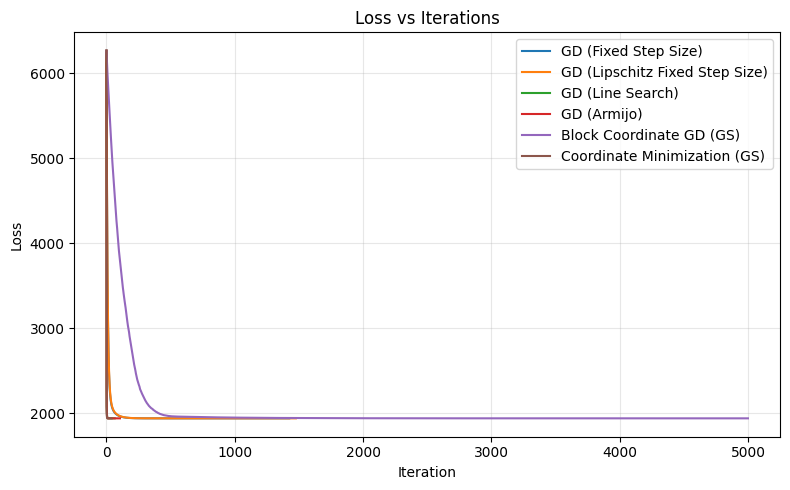

In [ ]:
# Dictionary for easy looping — label : history
histories_cancer = {
    "GD (Fixed Step Size)": history_gd_fss_cancer,
    "GD (Lipschitz Fixed Step Size)" : history_gd_Lp_cancer,
    "GD (Line Search)": history_gd_ls_cancer,
    "GD (Armijo)": history_gd_arm_cancer,
    "Block Coordinate GD (GS)": history_bcgd_cancer,
    "Coordinate Minimization (GS)": history_cm_cancer
}

plt.figure(figsize=(8, 5))
for label, hist in histories_cancer.items():
    plt.plot(hist["loss"], label=label)
plt.title("Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

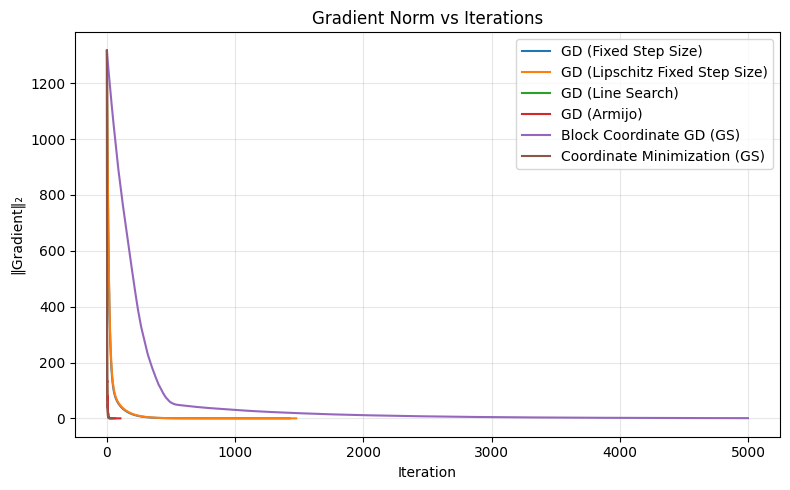

In [ ]:
plt.figure(figsize=(8, 5))
for label, hist in histories_cancer.items():
    plt.plot(hist["gap"], label=label)
plt.title("Gradient Norm vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("‖Gradient‖₂")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()